# Visualize Amazon Customer Reviews Dataset

### SageMaker IAM role needs the following policies
* AmazonAthenaFullAccess

### Dataset columns:

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
%%bash

pip install -q pandas==0.23.0
pip install -q numpy==1.14.3
pip install -q matplotlib==3.0.3
pip install -q seaborn==0.8.1
pip install -q PyAthena==1.8.0

In [2]:
# Imports & Settings

import boto3
import botocore
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Set Athena database & table 
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'


## List all Product Categories

In [3]:
# PyAthena imports
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [ ]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/staging/athena'.format(bucket)

In [6]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT DISTINCT product_category \
                FROM {0}.{1} \
                ORDER BY product_category'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_categories = as_pandas(cursor)
df_categories

,product_category
0,Apparel
1,Automotive
2,Baby
3,Beauty
4,Books
5,Camera
6,Digital_Ebook_Purchase
7,Digital_Music_Purchase
8,Digital_Software
9,Digital_Video_Download


## Ratings By Product Category

In [7]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                    COUNT(star_rating) AS count_star_rating \
                FROM {0}.{1} \
                WHERE LENGTH(review_body) > 20 \
                GROUP BY product_category \
                ORDER BY count_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_star_ratings = as_pandas(cursor)
df_star_ratings.head(10)

,product_category,count_star_rating
0,Books,19867676
1,Digital_Ebook_Purchase,18374357
2,Wireless,8164392
3,Video_DVD,6604815
4,PC,6473920
5,Mobile_Apps,6184175
6,Music,5858726
7,Home,5706934
8,Apparel,5231442
9,Health_&_Personal_Care,4867925


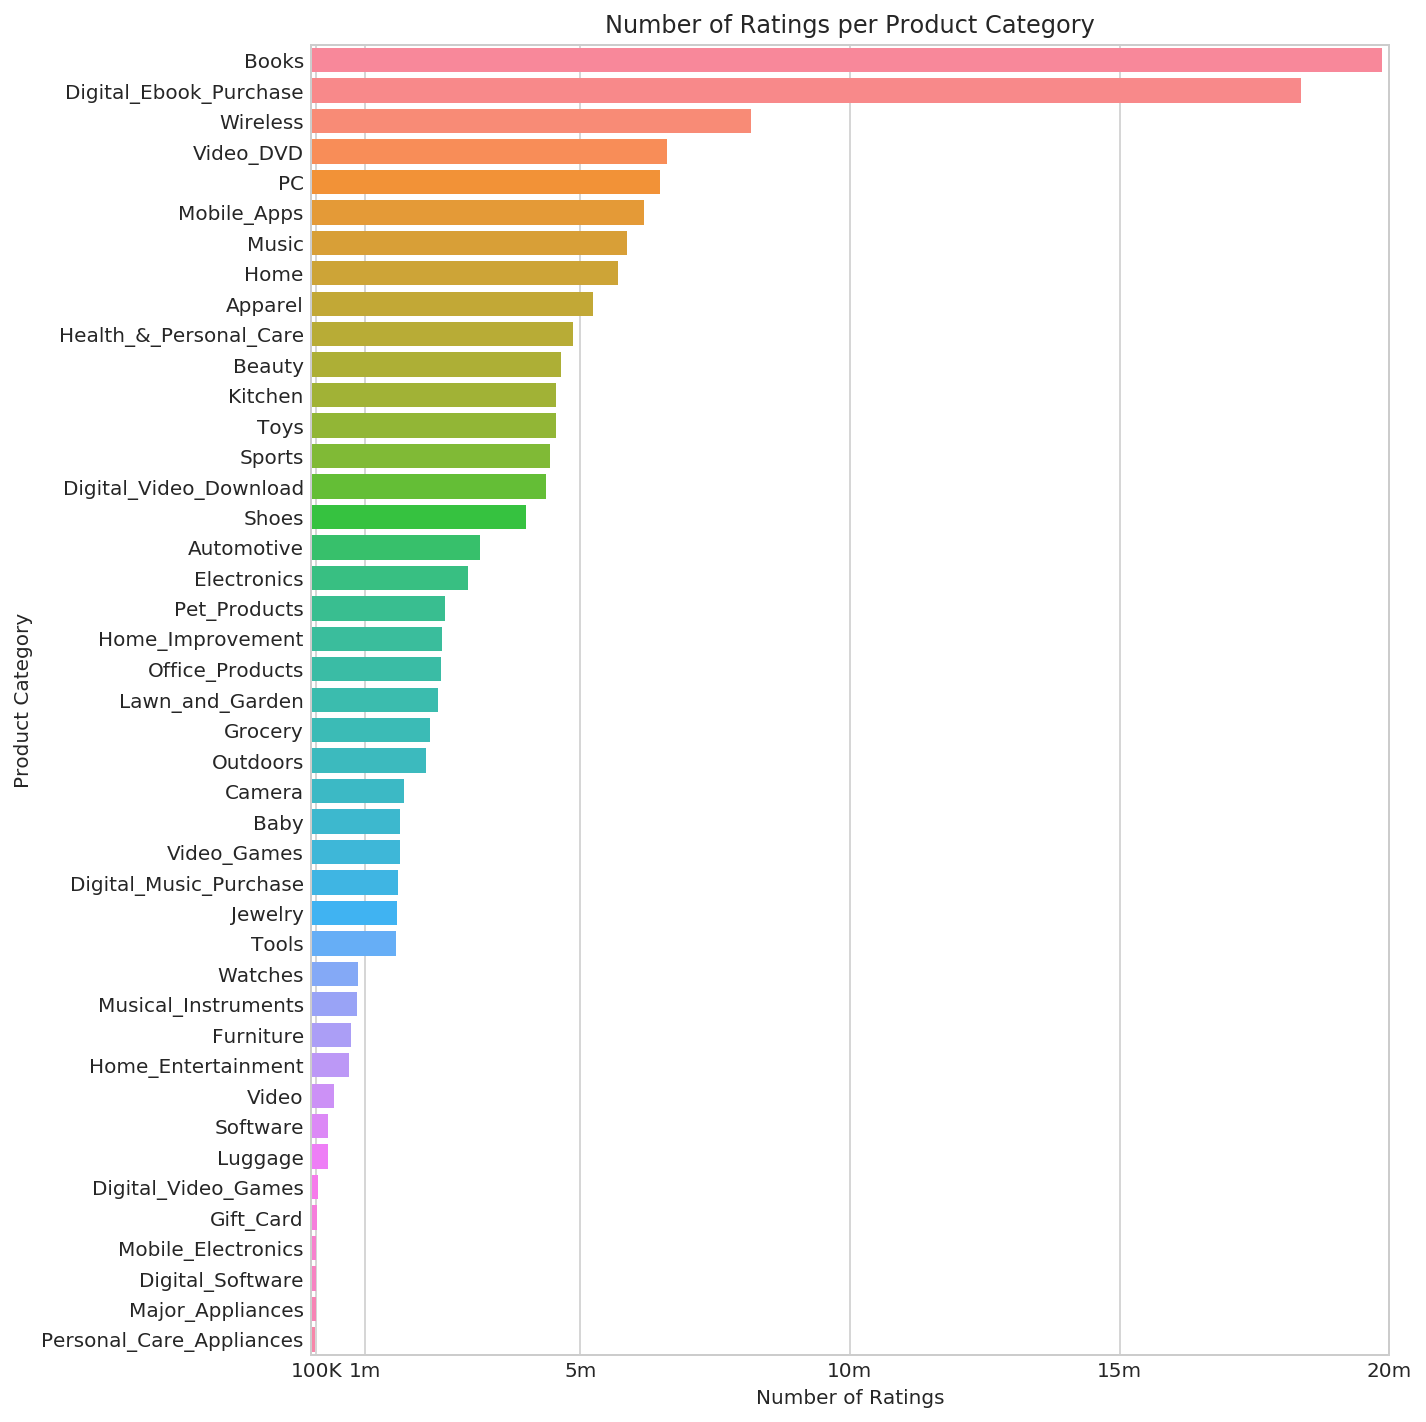

In [8]:
# Set size and style to use
plt.figure(figsize=(10,10))
plt.style.use('seaborn-whitegrid')

# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df_star_ratings, saturation=1)

# Set title
plt.title("Number of Ratings per Product Category")

# Set x-axis ticks to match scale from 10mio reviews to 20mio reviews
plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
plt.xlim(0, 20000000)
plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)


## Average Rating by Product Category

In [9]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                    AVG(star_rating) AS avg_star_rating \
                FROM {0}.{1} \
                WHERE LENGTH(review_body) > 20 \
                GROUP BY product_category \
                ORDER BY avg_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_average_ratings = as_pandas(cursor)
df_average_ratings.head(10)

,product_category,avg_star_rating
0,Gift_Card,4.688790
1,Digital_Music_Purchase,4.617928
2,Music,4.422334
3,Books,4.325457
4,Digital_Ebook_Purchase,4.308452
5,Grocery,4.281922
6,Video_DVD,4.272105
7,Tools,4.223428
8,Musical_Instruments,4.222266
9,Outdoors,4.212575


In [10]:
# Set some Seaborn parameters in advance

sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
#            "axes.facecolor":"white",
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

In [11]:
# Helper code to display values on bars

def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

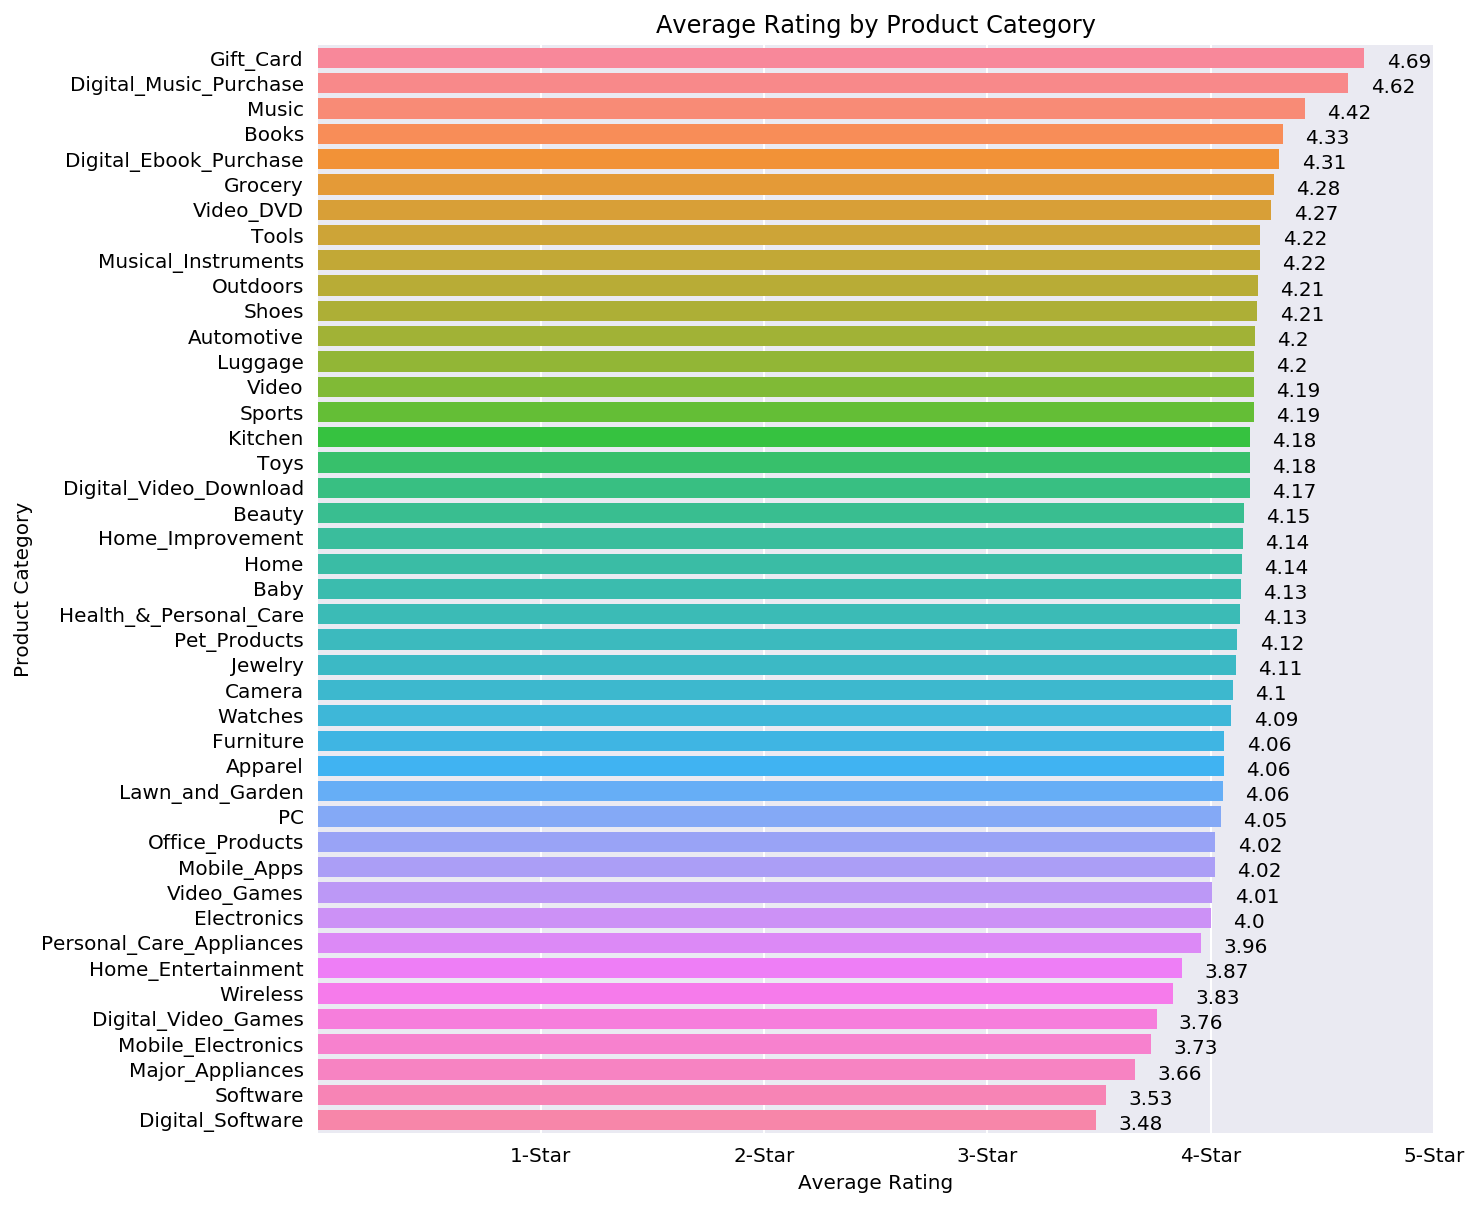

In [12]:
# Plot average ratings per category

# Create plot
barplot = sns.barplot(y='product_category', x='avg_star_rating', data = df_average_ratings, saturation=1)

# Set title and x-axis ticks 
plt.title('Average Rating by Product Category')
plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
# plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Rating Breakdown by Product Category

### First, calculate standard deviation and square root of number of reviews

In [13]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                         AVG(star_rating) AS avg_star_rating, \
                         STDDEV(star_rating) AS stddev_star_rating, \
                         SQRT(COUNT(*)) AS sqrt_count \
                FROM {}.{} \
                WHERE LENGTH(review_body) > 20 \
                GROUP BY product_category \
                ORDER BY avg_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_avg_stddev_sqrt = as_pandas(cursor)
df_avg_stddev_sqrt.head(10)

,product_category,avg_star_rating,stddev_star_rating,sqrt_count
0,Gift_Card,4.688790,0.898225,343.844442
1,Digital_Music_Purchase,4.617928,0.889604,1274.123228
2,Music,4.422334,1.048247,2420.480531
3,Books,4.325457,1.136426,4457.317130
4,Digital_Ebook_Purchase,4.308452,1.065993,4286.532048
5,Grocery,4.281922,1.251147,1484.395163
6,Video_DVD,4.272105,1.200422,2569.983463
7,Tools,4.223428,1.239165,1259.828560
8,Musical_Instruments,4.222266,1.233100,924.537182
9,Outdoors,4.212575,1.225925,1463.190008


### Then, calculate standard deviation mean

In [14]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                         AVG(star_rating) AS avg_star_rating, \
                         (STDDEV(star_rating) / SQRT(COUNT(*))) AS sd_mean \
                FROM {}.{} \
                WHERE LENGTH(review_body) > 20 \
                GROUP BY product_category \
                ORDER BY avg_star_rating DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_breakdown_category_avg = as_pandas(cursor)
df_breakdown_category_avg.head(10)

,product_category,avg_star_rating,sd_mean
0,Gift_Card,4.688790,0.002612
1,Digital_Music_Purchase,4.617928,0.000698
2,Music,4.422334,0.000433
3,Books,4.325457,0.000255
4,Digital_Ebook_Purchase,4.308452,0.000249
5,Grocery,4.281922,0.000843
6,Video_DVD,4.272105,0.000467
7,Tools,4.223428,0.000984
8,Musical_Instruments,4.222266,0.001334
9,Outdoors,4.212575,0.000838


## Number of reviews per star per category

In [15]:
# Execute query using connection cursor
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT product_category, \
                         star_rating, \
                         COUNT(*) AS count_reviews \
                FROM {}.{} \
                WHERE LENGTH(review_body) > 20 \
                GROUP BY  product_category, star_rating \
                ORDER BY  product_category, star_rating ASC, count_reviews DESC'
               .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_breakdown_category = as_pandas(cursor)
df_breakdown_category.head(10)

,product_category,star_rating,count_reviews
0,Apparel,1,415884
1,Apparel,2,349272
2,Apparel,3,581986
3,Apparel,4,1038336
4,Apparel,5,2845964
5,Automotive,1,287451
6,Automotive,2,142920
7,Automotive,3,227422
8,Automotive,4,479276
9,Automotive,5,1994349


In [16]:
# Create grouped DataFrames by category and by star rating
grouped_category = df_breakdown_category.groupby('product_category')
grouped_star = df_breakdown_category.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df_breakdown_category.groupby(['star_rating']).sum()
df_sum.head(10)

,count_reviews
star_rating,
1,12174447
2,7463799
3,12328295
4,26346351
5,90402611


In [17]:
# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

148715503


In [18]:
# Create dictionary of product categories and array of star rating distribution per category

distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.get_value(i, 'count_reviews'))
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)


{'Apparel': [415884, 349272, 581986, 1038336, 2845964], 'Automotive': [287451, 142920, 227422, 479276, 1994349], 'Baby': [141867, 99692, 147240, 278152, 996299], 'Beauty': [435831, 254409, 378089, 685720, 2895106], 'Books': [1097588, 851984, 1506899, 3441490, 12969715], 'Camera': [167650, 90730, 139783, 328167, 996267], 'Digital_Ebook_Purchase': [776389, 728171, 1637219, 4142248, 11090330], 'Digital_Music_Purchase': [50707, 27489, 64026, 206905, 1274263], 'Digital_Software': [23312, 6775, 8007, 15728, 42094], 'Digital_Video_Download': [319168, 226588, 399292, 850305, 2573785], 'Digital_Video_Games': [24038, 7561, 11137, 19155, 67139], 'Electronics': [348999, 177148, 232341, 512653, 1640223], 'Furniture': [71402, 42922, 71709, 148165, 418653], 'Gift_Card': [4607, 1521, 2817, 8169, 101115], 'Grocery': [173585, 101885, 154390, 273458, 1500111], 'Health_&_Personal_Care': [485100, 266365, 378547, 723537, 3014376], 'Home': [527014, 314490, 479927, 899179, 3486324], 'Home_Entertainment': [101

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [ ]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

In [ ]:
# Check if star rating distributions are set correctly
print(distribution.items())

### Build array per star across all categories

In [19]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

df_average_ratings.iloc[:,0]
for index, value in df_average_ratings.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

In [20]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star1.append(stars[0])
    star2.append(stars[1])
    star3.append(stars[2])
    star4.append(stars[3])
    star5.append(stars[4])
               

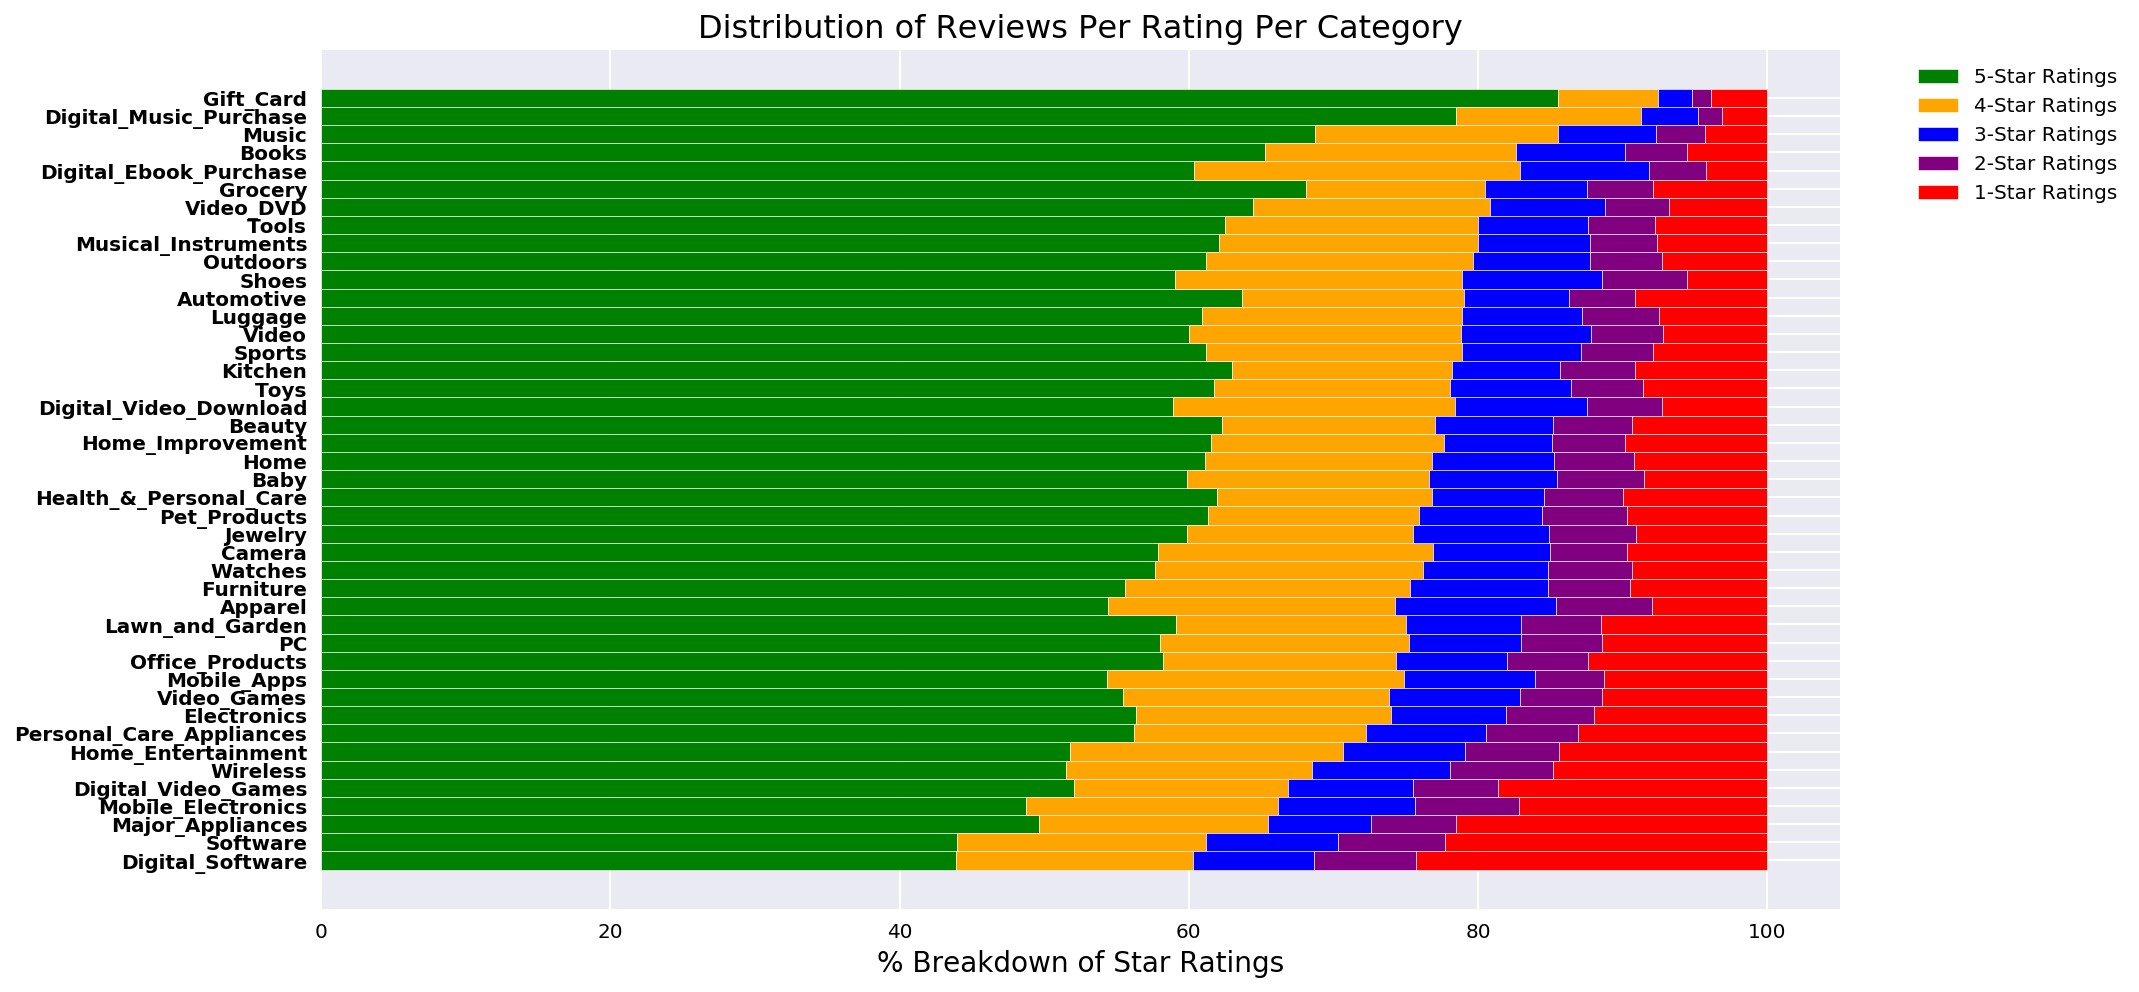

In [21]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
plt.figure(figsize=(15,7))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='bold')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()

plt.tight_layout()

# Save if needed
# plt.savefig("star_distribution_category_stacked.png", dpi=300)

plt.show()


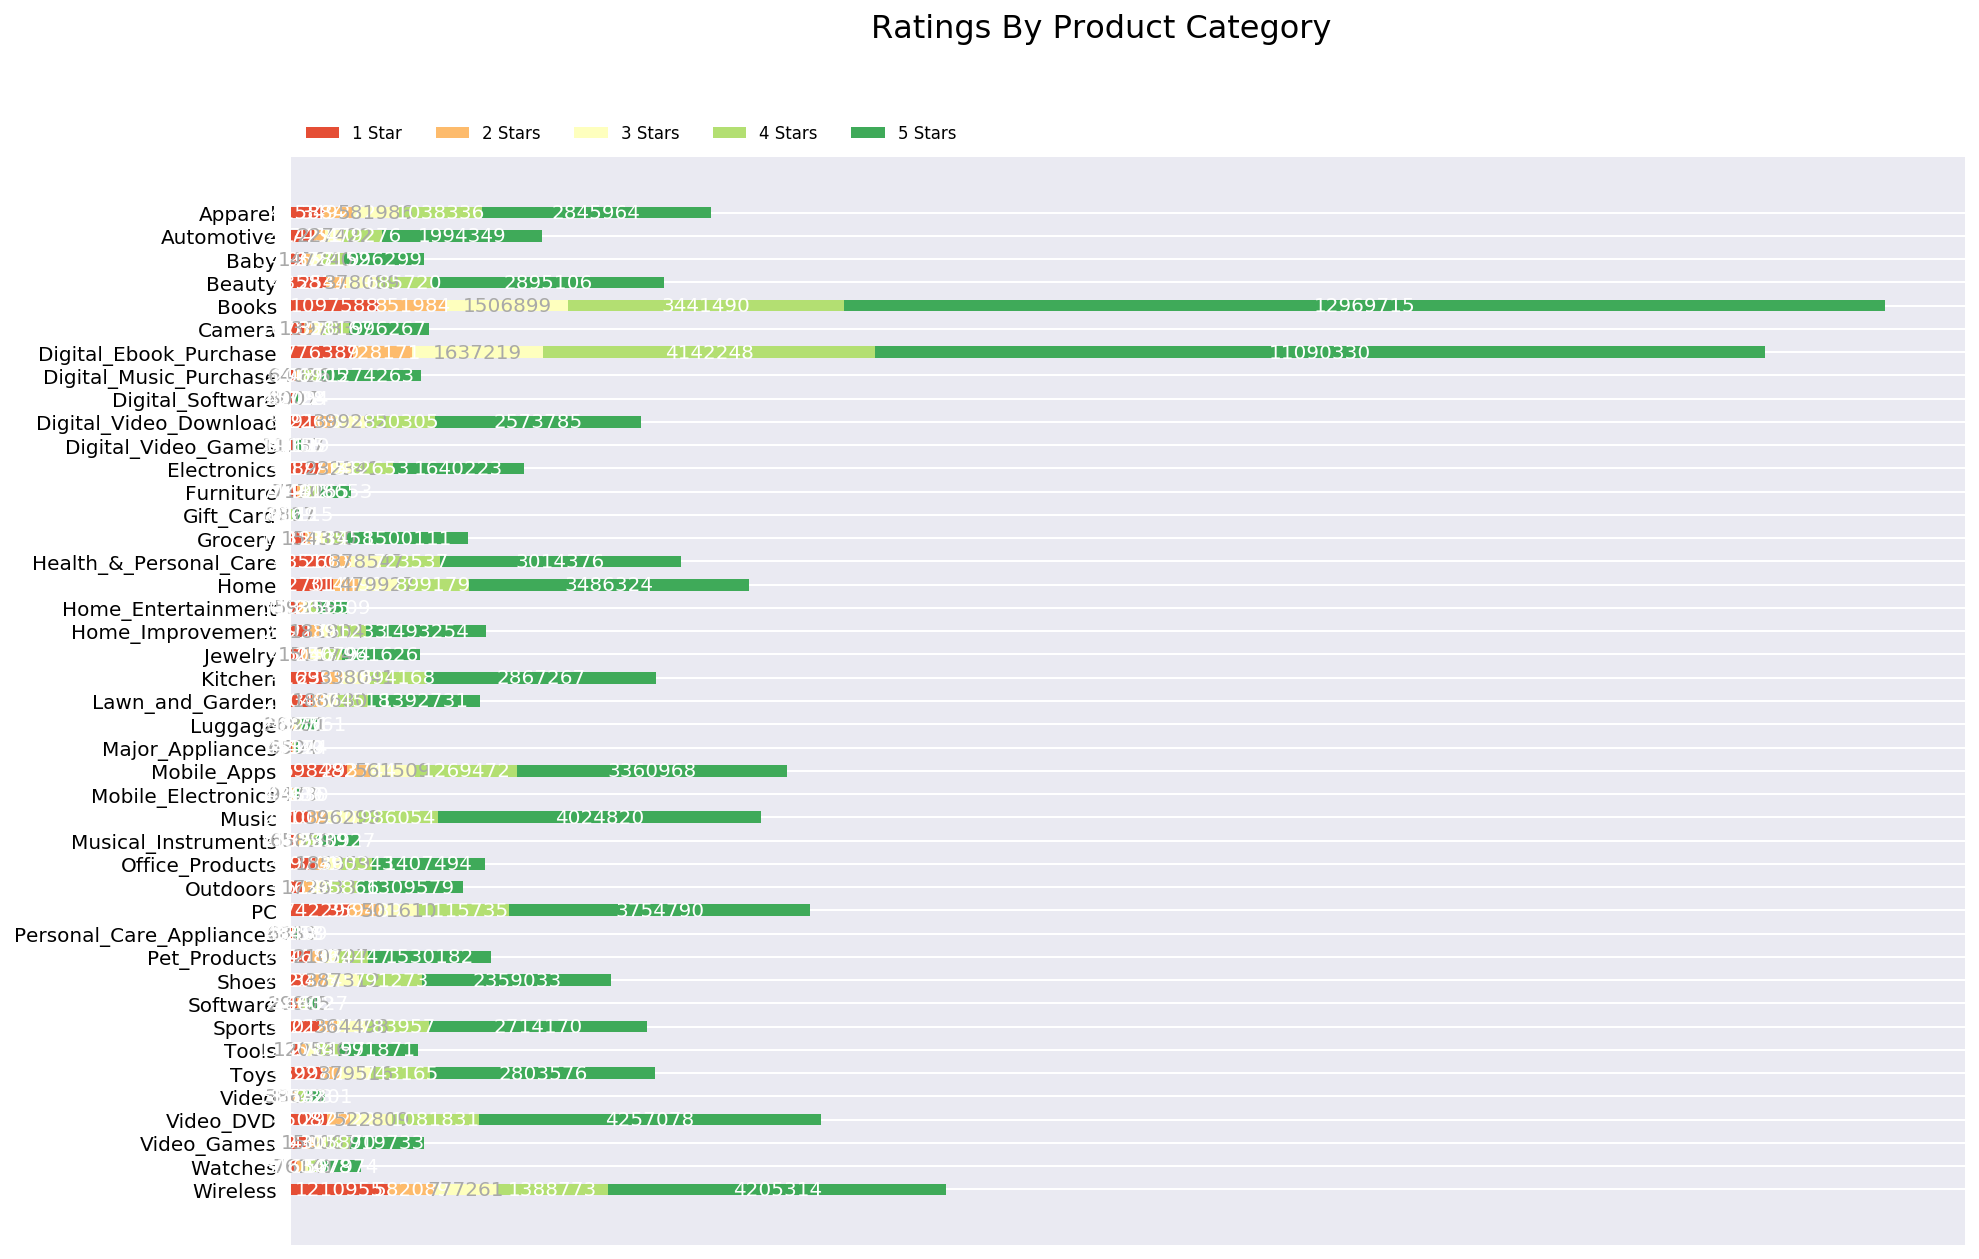

In [22]:
# Alternative way to get to the distribution figure above

scores = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

def bar_chart(distribution, scores):

    labels = list(distribution.keys())
    data = np.array(list(distribution.values()))
    data_cum = data.cumsum(axis=1)
    score_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(scores, score_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)), ha='center', va='center',
                    color=text_color)
    ax.legend(ncol=len(scores), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    fig.suptitle('Ratings By Product Category', fontsize=16)
#    ax.axis('scaled')
    return fig, ax


bar_chart(distribution, scores)
plt.autoscale(enable=True, axis='both', tight=None)
plt.show()

## Translate Ratings into Sentiment

**Attention**: the SQL query below can take a long time on large datasets, hence set a LIMIT if you run it from within the notebook, or execute the query in the Athena Console directly. 

In [23]:
# Execute query using connection cursor      
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

# If rating > 3, sentiment = 1 (positive), else 0 (negative)
cursor.execute('SELECT customer_id, \
                         product_id, \
                         star_rating, \
                         CASE \
                             WHEN star_rating > 3 THEN 1 \
                             ELSE 0 \
                         END \
                AS sentiment \
                FROM {}.{} \
                WHERE LENGTH(review_body) > 20 \
                ORDER BY review_id \
                LIMIT 10000'
                .format(database_name, table_name))

# Load query results into Pandas DataFrame and show results
df_sentiment = as_pandas(cursor)
df_sentiment.head(10)

,customer_id,product_id,star_rating,sentiment
0,20227669,B002NIWBBI,5,1
1,44734422,1438277733,5,1
2,39049108,B00KEXUWQA,4,1
3,24937700,B003V61JSW,4,1
4,40275859,B000ASB3RG,5,1
5,9925437,B004NKY23E,3,0
6,31353327,B004WTJAAG,5,1
7,36697166,B00575T15S,5,1
8,34450301,B00J1VV792,1,0
9,27622223,B00DPK9NI2,4,1


## Python [Wordcloud](http://amueller.github.io/word_cloud/) Visualization

See the most popular words in the dataset using a Wordcloud visualization.
Attention, the SQL query below can take a long time on large datasets, hence set a LIMIT.

In [24]:
!python -m pip install wordcloud -q

In [25]:
# Execute query using connection cursor     
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()

cursor.execute('SELECT review_body, \
                         CASE \
                             WHEN star_rating > 3 THEN 1 \
                             ELSE 0 \
                         END \
                AS sentiment \
                FROM {}.{} \
                WHERE LENGTH(review_body) > 20 \
                ORDER BY review_id \
                LIMIT 10000'
                .format(database_name, table_name))

df_reviews = as_pandas(cursor)
df_reviews.head(10)

,review_body,sentiment
0,Just couldn't find a copy so I bought this one...,1
1,Dave Atwood has summarized his own first hand ...,1
2,Very nice product.I bought it to replace a dif...,1
3,公開されたときはコケた映画ですが、僕はめちゃ好きです。<br />シュワちゃんのコミカルな演...,1
4,"While our cat was suffering with skin cancer, ...",1
5,"I would give this item five stars, however the...",0
6,Same as the other ones,1
7,When I first looked at the quilt in its packag...,1
8,This is the most useless trash. The readings ...,0
9,Good bedtime reading if you go to bed early ca...,1


Note: To remove HTML markup like the word `br` in the `review_body`, use [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [26]:
import bs4
df_reviews['review_body'] = df_reviews['review_body'].apply(lambda x: bs4.BeautifulSoup(x, 'lxml').get_text())
df_reviews

,review_body,sentiment
0,Just couldn't find a copy so I bought this one...,1
1,Dave Atwood has summarized his own first hand ...,1
2,Very nice product.I bought it to replace a dif...,1
3,公開されたときはコケた映画ですが、僕はめちゃ好きです。シュワちゃんのコミカルな演技が素晴らし...,1
4,"While our cat was suffering with skin cancer, ...",1
5,"I would give this item five stars, however the...",0
6,Same as the other ones,1
7,When I first looked at the quilt in its packag...,1
8,This is the most useless trash. The readings ...,0
9,Good bedtime reading if you go to bed early ca...,1


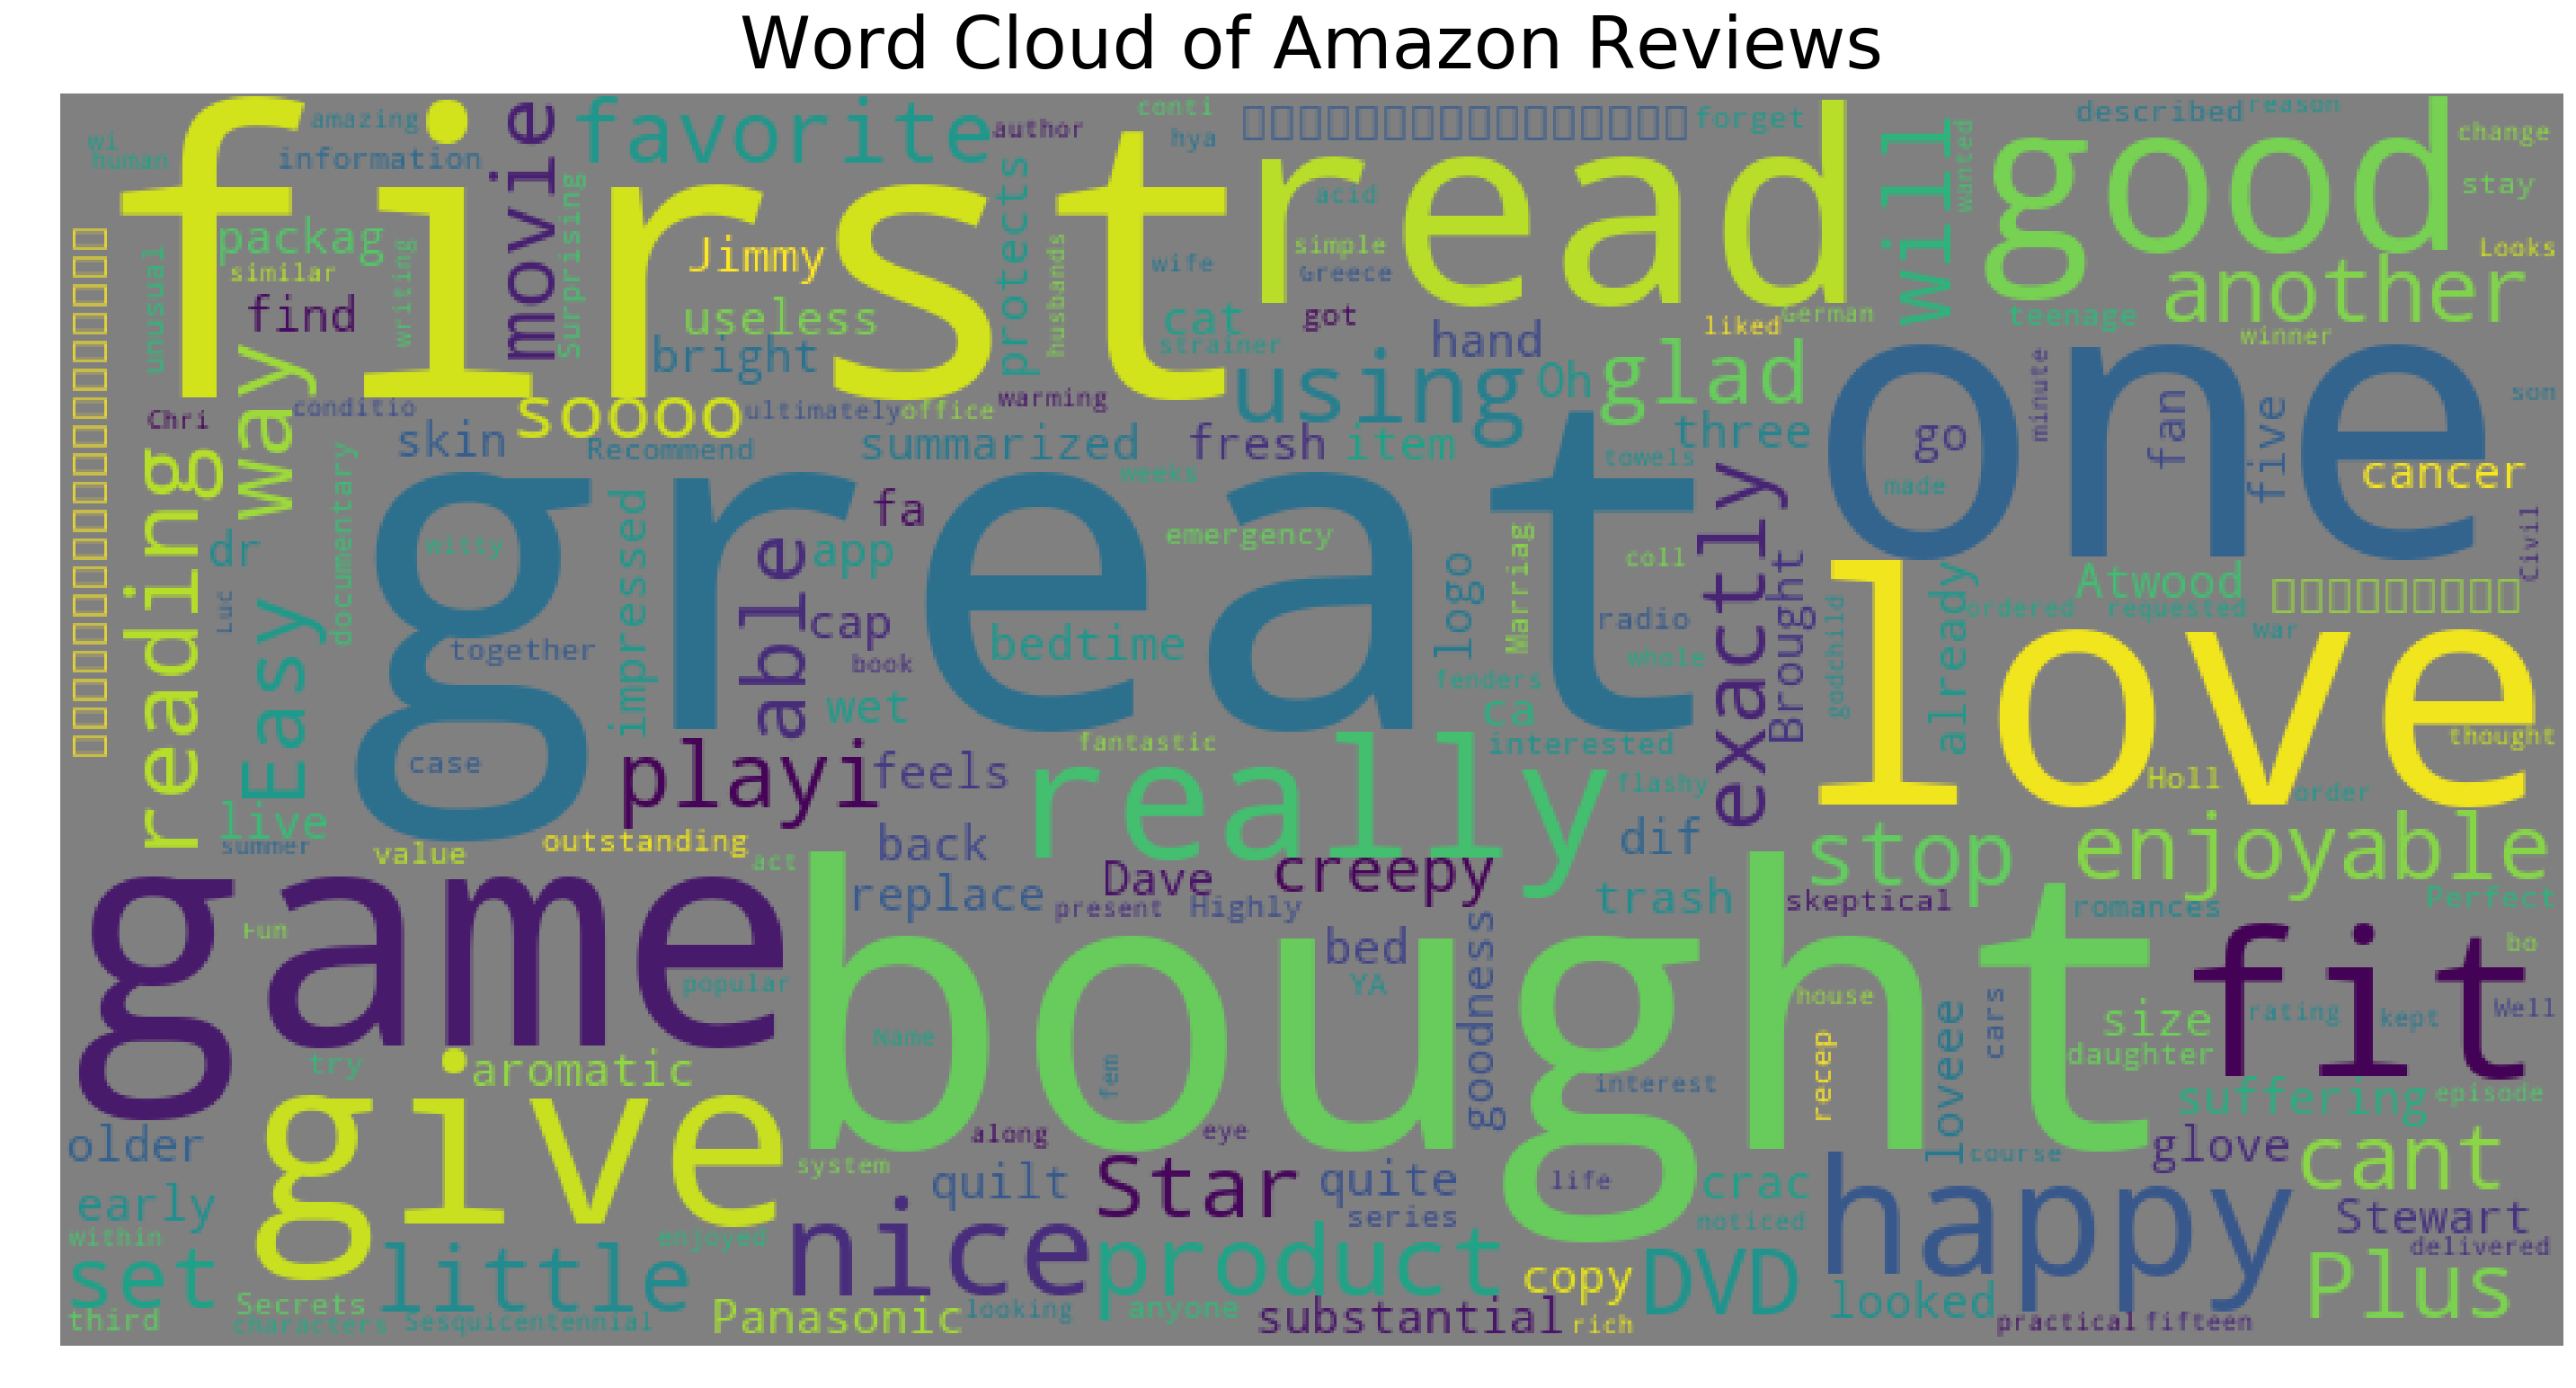

In [27]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=150, figure_size=(20.0,15.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color='gray',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 50,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                   'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                   'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(df_reviews['review_body'], title="Word Cloud of Amazon Reviews")

## Let's do some further text analysis
* Number of words
* Number of unique words
* Number of characters in the text
* Number of stopwords in the text
* Number of punctuations in the text
* Average length of the words in the text

In [28]:
import string

## Number of words in the text ##
df_reviews["num_words"] = df_reviews["review_body"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
df_reviews["num_unique_words"] = df_reviews["review_body"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
df_reviews["num_chars"] = df_reviews["review_body"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
df_reviews["num_stopwords"] = df_reviews["review_body"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text ##
df_reviews["num_punctuations"] = df_reviews['review_body'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
df_reviews["mean_word_len"] = df_reviews["review_body"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [29]:
df_reviews.describe()

,sentiment,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.78280,70.374100,49.854500,388.131900,33.907600,11.990400,4.781673
std,0.41236,121.222057,60.089004,693.845056,57.513748,23.844667,10.329167
min,0.00000,1.000000,1.000000,13.000000,0.000000,0.000000,2.300000
25%,1.00000,21.000000,20.000000,111.000000,9.000000,3.000000,4.078947
50%,1.00000,35.000000,31.000000,185.000000,17.000000,5.000000,4.380141
75%,1.00000,72.000000,58.000000,392.000000,36.000000,11.000000,4.735575
max,1.00000,2161.000000,786.000000,11311.000000,1111.000000,446.000000,549.000000


### Truncate extreme values

In [30]:
df_reviews = df_reviews.query('num_words <= 500 and num_punctuations < 500')

### Let's plot number of words, number of characters and number of punctuations in each class using Violin plots

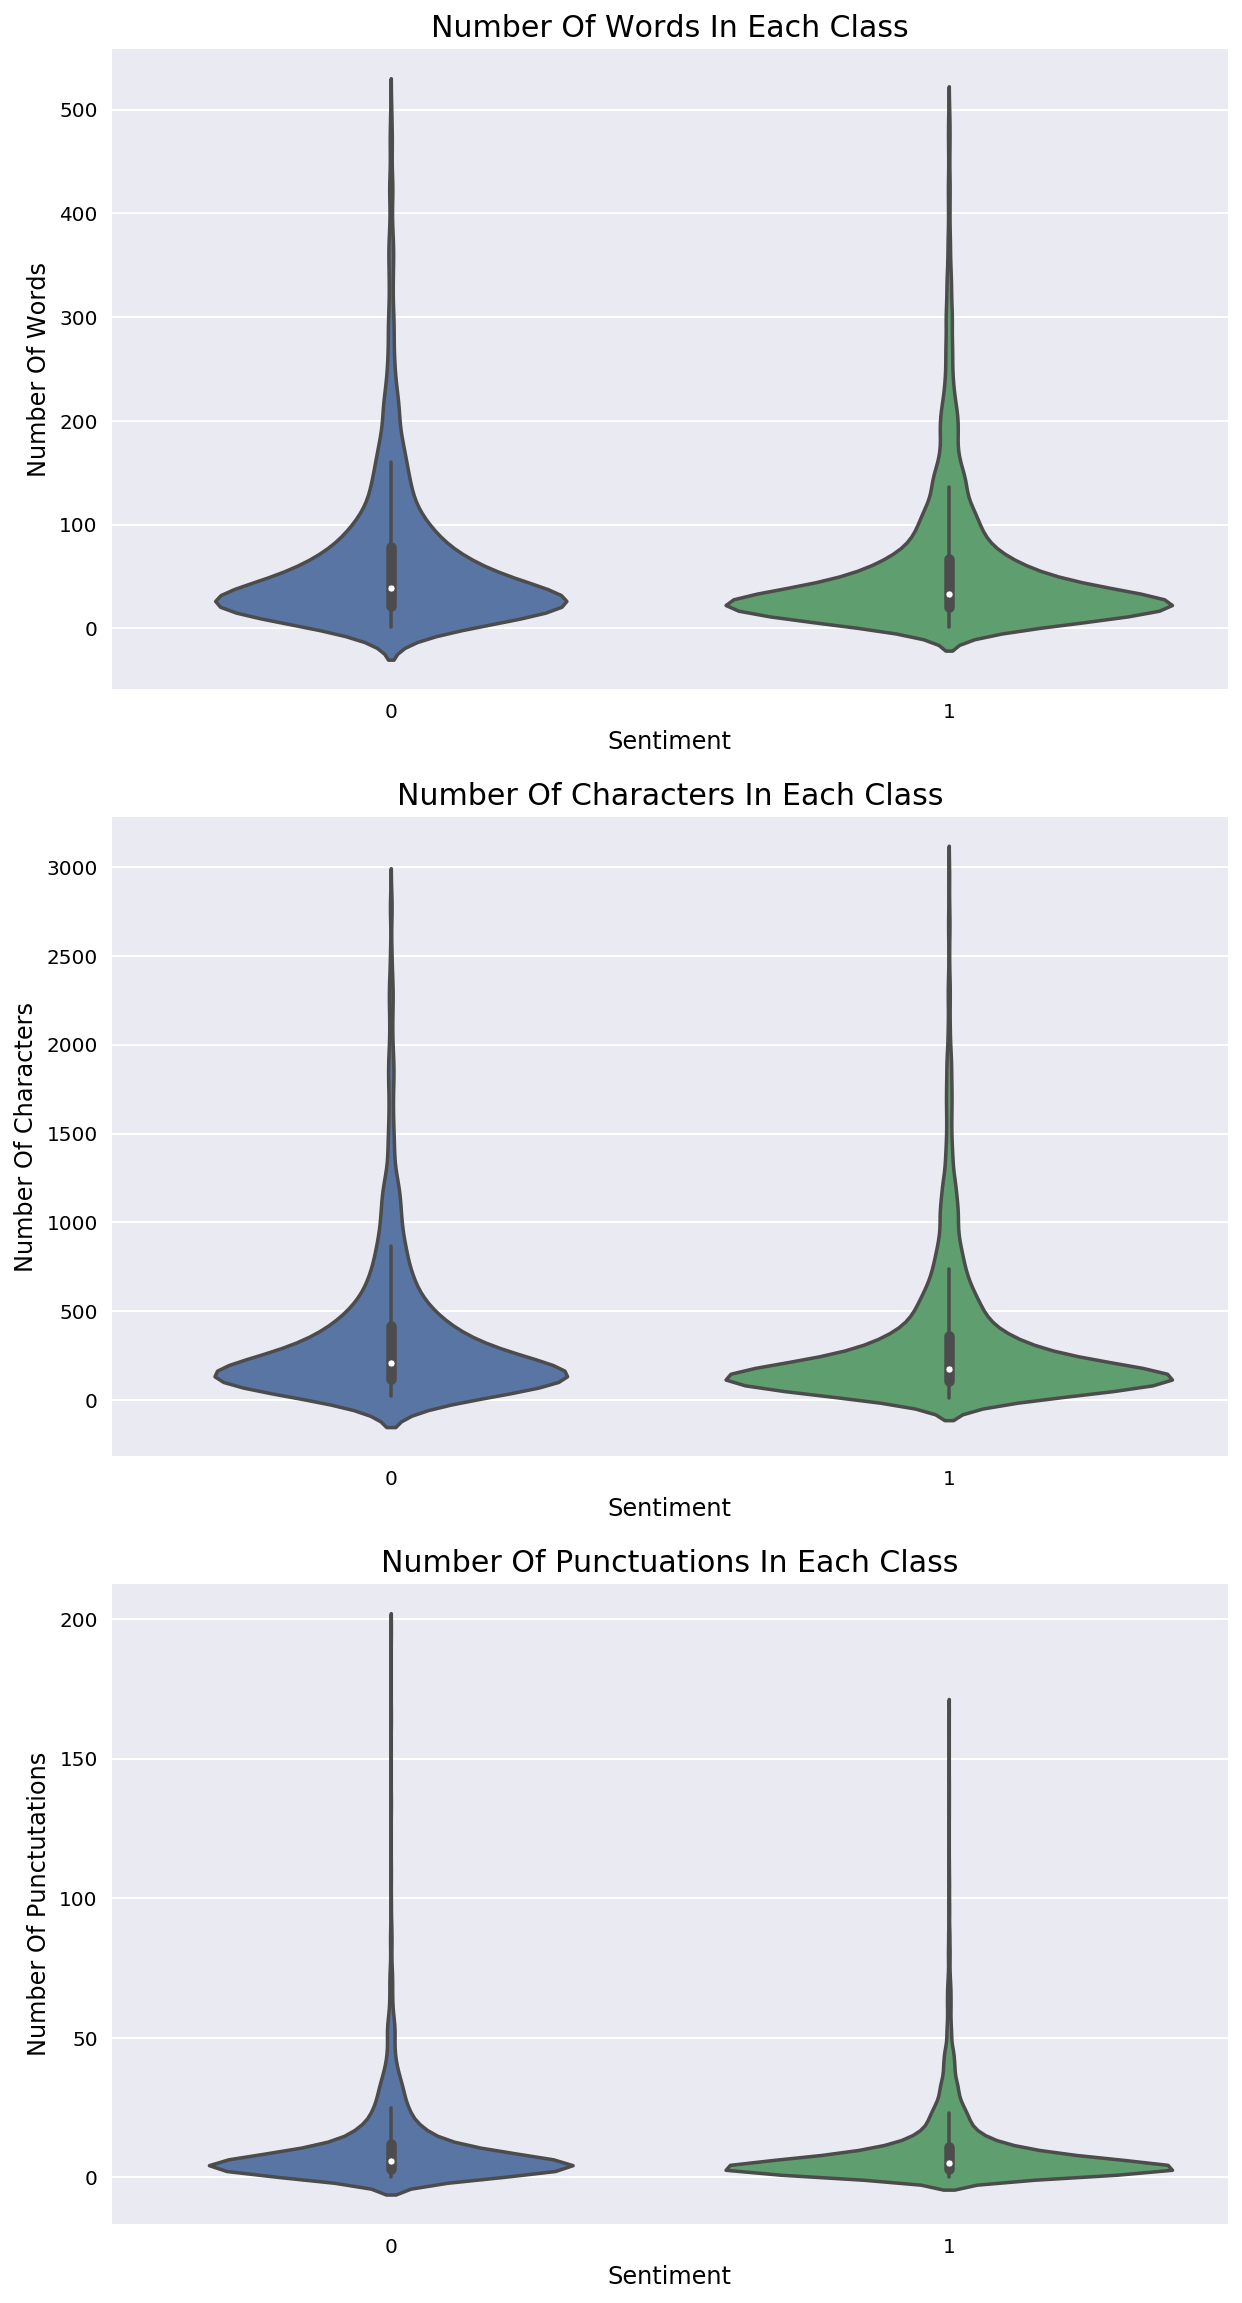

In [34]:
f, axes = plt.subplots(3, 1, figsize=(10,20))

sns.violinplot(x='sentiment', y='num_words', data=df_reviews, ax=axes[0])
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Number Of Words', fontsize=12)
axes[0].set_title("Number Of Words In Each Class", fontsize=15)

sns.violinplot(x='sentiment', y='num_chars', data=df_reviews, ax=axes[1])
axes[1].set_xlabel('Sentiment', fontsize=12)
axes[1].set_ylabel('Number Of Characters', fontsize=12)
axes[1].set_title("Number Of Characters In Each Class", fontsize=15)

sns.violinplot(x='sentiment', y='num_punctuations', data=df_reviews, ax=axes[2])
axes[2].set_xlabel('Sentiment', fontsize=12)
axes[2].set_ylabel('Number Of Punctutations', fontsize=12)
axes[2].set_title("Number Of Punctuations In Each Class", fontsize=15)
plt.show()

### Start thinking about balancing positive vs. negative reviews

1    7716
0    2138
Name: sentiment, dtype: int64


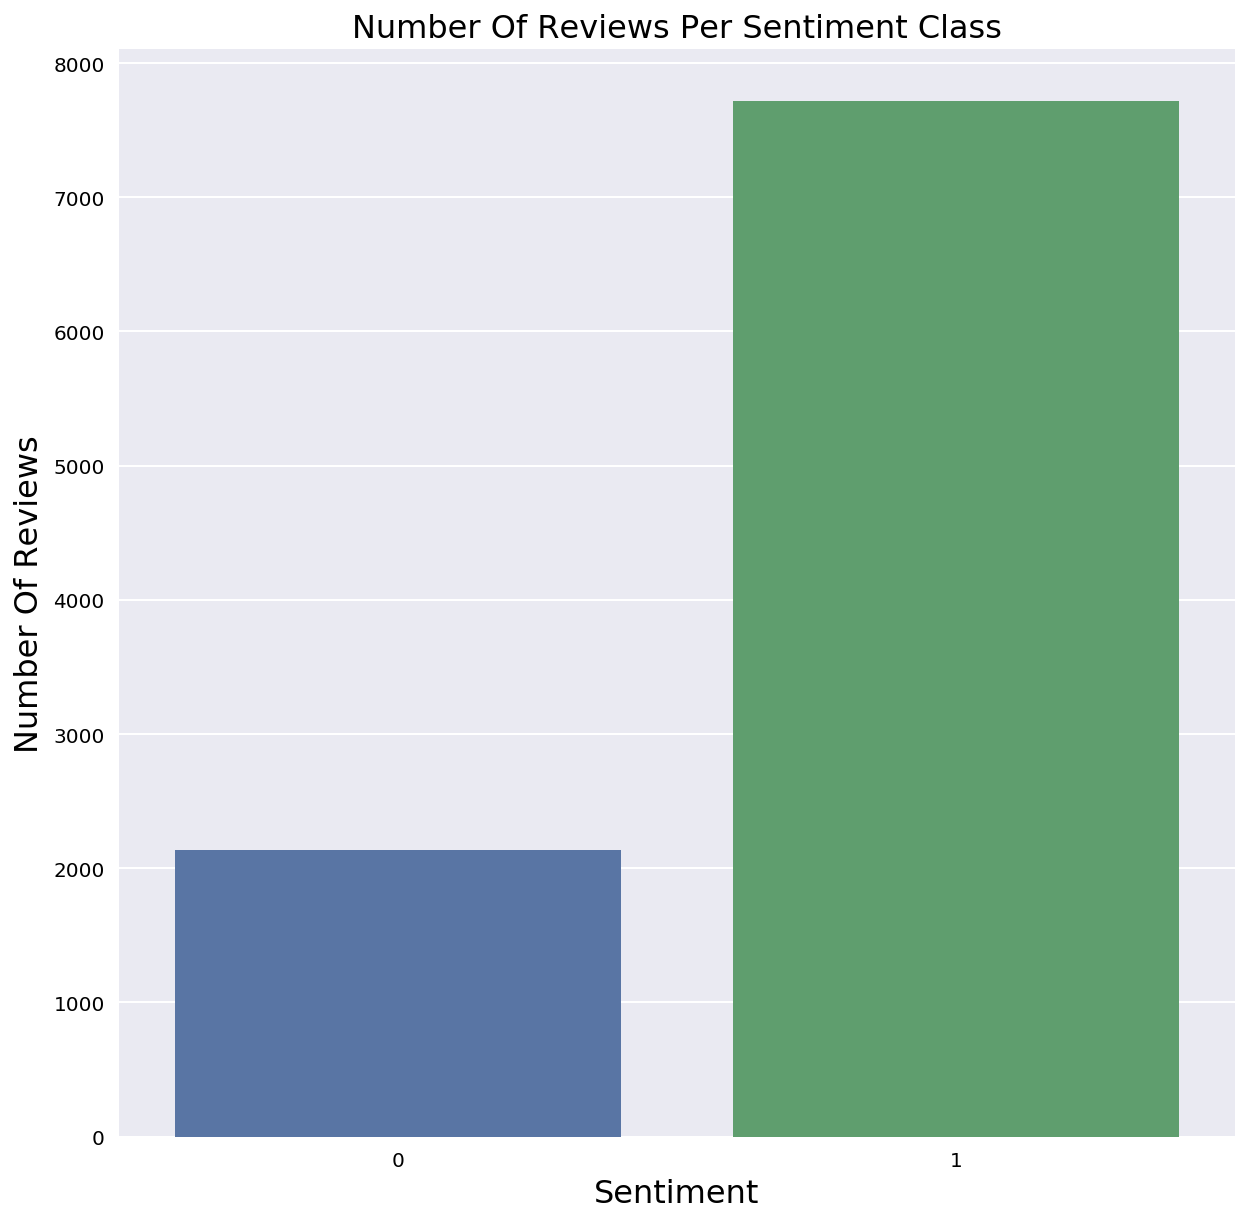

In [47]:
# Count number of reviews per sentiment class
print(df_reviews['sentiment'].value_counts())

# Create Plot
plot = sns.countplot(x='sentiment', data=df_reviews)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Number Of Reviews", fontsize=16)
plt.title("Number Of Reviews Per Sentiment Class", fontsize=16)

plt.show(plot)

### Handling imbalanced datasets

Here you can see we have a larger number of `positive` samples vs. `negative` ones. There are a number of techniques to blance this dataset out and the two most popular approaches are to either under-sample or over-sample. With under sampling you remove rows to balance the dataset out and in over sampling you can duplicate entries in the daatset which could lead to overfitting. This discussion is beyond the scope of this lab. You will under sample the data to balance the dataset but you can find more information [here]().

1    2138
0    2138
Name: sentiment, dtype: int64


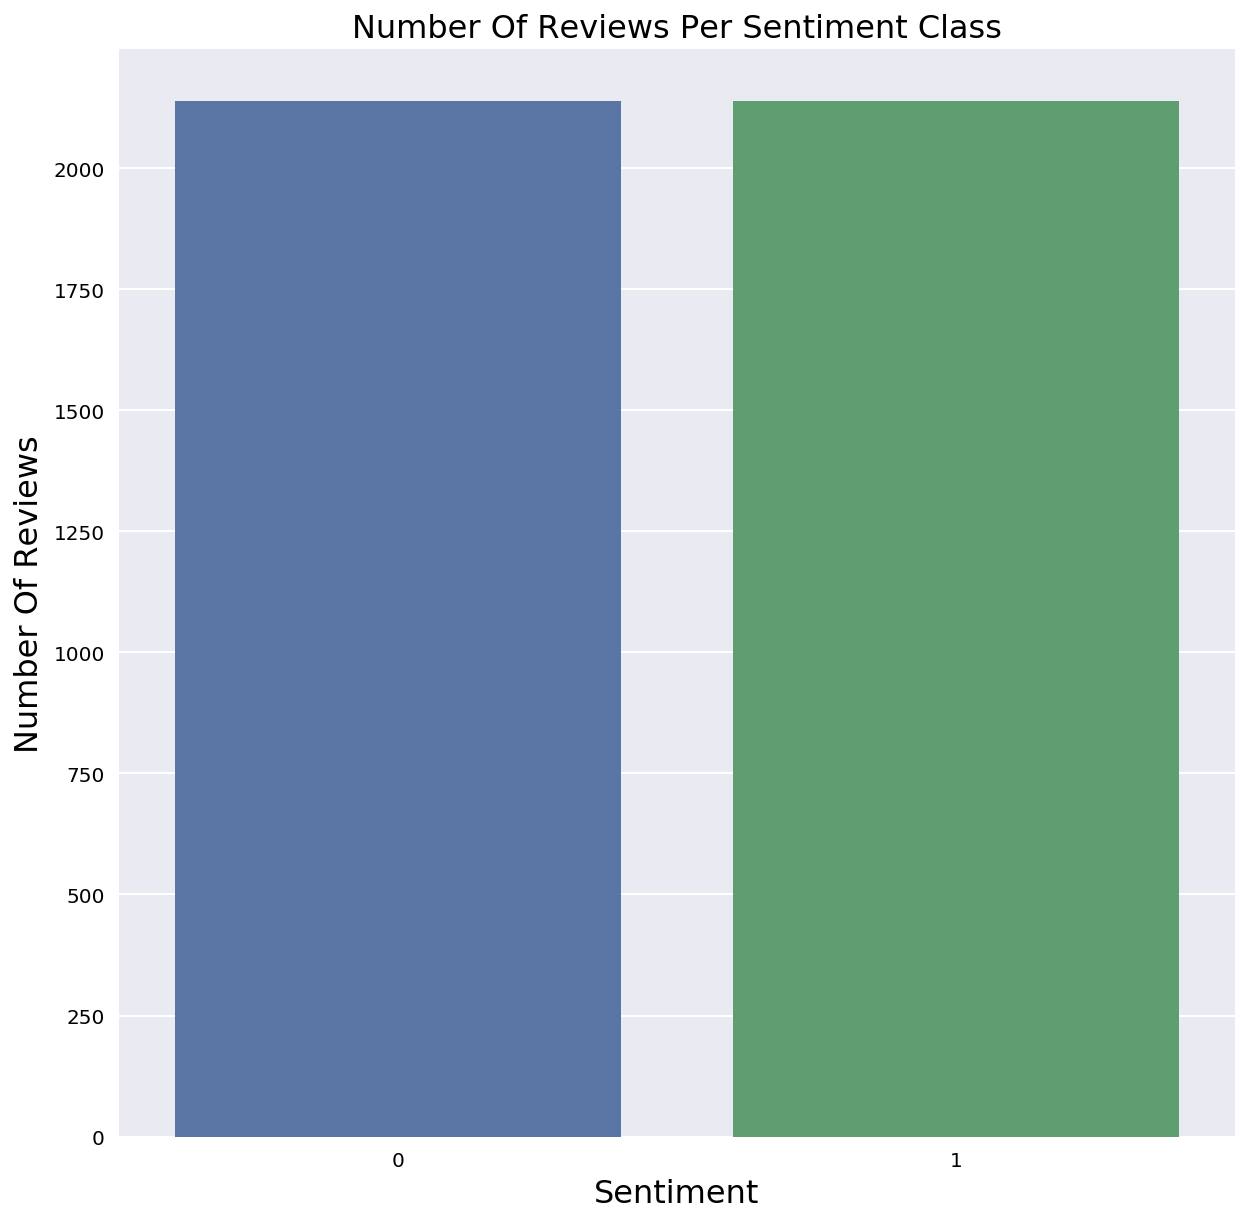

In [49]:
from sklearn.utils import resample

positive = df_reviews[df_reviews['sentiment']==1]
negative = df_reviews[df_reviews['sentiment']==0]

positive_downsampled = resample(positive,
                                replace = False, # sample without replacement
                                n_samples = len(negative), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([positive_downsampled, negative])

# checking counts
print(downsampled['sentiment'].value_counts())

# Create Plot
plot = sns.countplot(x='sentiment', data=downsampled)
plt.xlabel("Sentiment", fontsize=16)
plt.ylabel("Number Of Reviews", fontsize=16)
plt.title("Number Of Reviews Per Sentiment Class", fontsize=16)

plt.show(plot)

### Create Test, Train, and Validation Datasets

Depending on the framework you are leveraging in your AI/ML workloads you may decide to split the data into test, train, and validate splits before uploading to S3. You can leverage some built in functions in the sklearn package to do the split. To learn more about the sklearn framework click [here](https://scikit-learn.org/stable/).

In [50]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(downsampled, test_size=0.2, random_state=0)
test, validate = train_test_split(test, test_size=0.5, random_state=0)

print(f'Number of training examples: {len(train.index)}')
print(f'Number of testing examples: {len(test.index)}')
print(f'Number of validation examples: {len(validate.index)}')


Number of training examples: 3420
Number of testing examples: 428
Number of validation examples: 428


### Visualize the Train, Test, and Validation Split

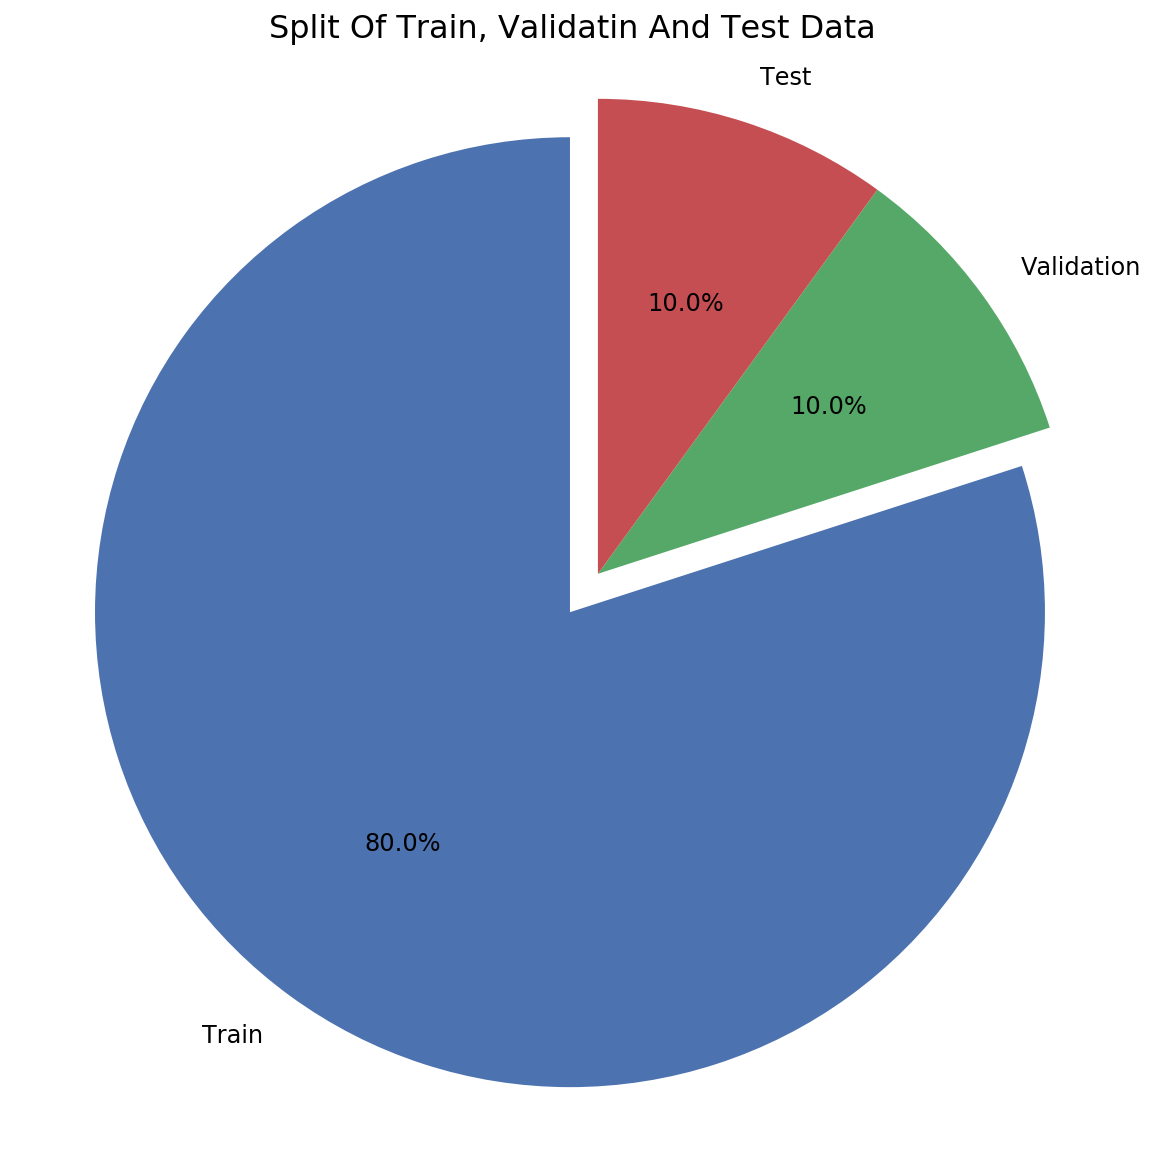

In [57]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

labels = ['Train', 'Validation', 'Test']
sizes = [len(train.index), len(validate.index), len(test.index)]
explode = (0.1, 0, 0)  

fig1, ax1 = plt.subplots()

ax1.set_title("Split Of Train, Validatin And Test Data", fontsize=16)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12})

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis('equal')  
plt.show()

## Optional - SQL Magic in Jupyter Notebooks

You can use the built-in functionality in Jupyter to create shortcut magic commands to fit your needs. Here we will use the pyathena library like above to query the review data, but this time we will encapsulate the call in the Jupyter magic command.

In [58]:
import pyathena
from pyathena.util import as_pandas

from IPython.core import magic_arguments
from IPython.core.magic import cell_magic, Magics, magics_class


def query_athena(sql, region_name, s3_staging_dir):
    cursor = pyathena.connect(
        region_name=region_name,
        s3_staging_dir="{}".format(s3_staging_dir)).cursor()
    cursor.execute(sql)
    return cursor

@magics_class
class AthenaMagics(Magics):
    s3_staging_dir = None
    region_name = None

    
    def parse_args(self, line):
        args = magic_arguments.parse_argstring(self.athena, line)

        # s3 staging directory
        if args.s3_staging_dir is None and self.s3_staging_dir is None:
            raise ValueError("s3_staging_dir for Athena should be set")
        if args.s3_staging_dir is not None:
            self.s3_staging_dir = args.s3_staging_dir
 
        # region name
        if args.region_name is None and self.region_name is None:
            raise ValueError("region_name for Athena should be set")
        if args.region_name is not None:
            self.region_name = args.region_name
 
    @cell_magic
    @magic_arguments.magic_arguments()
    @magic_arguments.argument('--s3_staging_dir', '-s',
        help='s3 path required by athena for writing query results (e.g. s3://your/staging/dir)'
    )
    @magic_arguments.argument('--region_name', '-r',
        help='aws region name (e.g. us-west-2)'
    )
    def athena(self, line='', cell=None):
        self.parse_args(line)
        cursor = query_athena(cell, self.region_name, self.s3_staging_dir)
        return as_pandas(cursor)

    
ip = get_ipython()
ip.register_magics(AthenaMagics)

Now that the magic is registered you can use the `%%athena` magic to query data registered in your Glue Data Catalog.

**Replace the {{region}} and {{bucket/temp}} with the region and bucket variable values above Ex.**

```%%athena -r us-west-2 -s s3://[your-staging-s3-bucket]```

In [62]:
%%athena -r us-east-1 -s $s3_staging_dir

select * from dsoaws.amazon_reviews_parquet limit 10;

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,product_category
0,US,4726409,R3EASH6JSOM0Z3,BT00CTOYI4,384589818,Amazon.com $25 Gift Card in a Greeting Card (A...,1,1,1,N,Y,I have not purchase or received an Amazon Gift...,I have never purchased or received an Amazon g...,16169,2014,Gift_Card
1,US,51620480,RW7HZIW91MZ1I,B00IYVZ1BU,439779608,Amazon eGift Card - Congratulations (Typography),5,0,0,N,Y,"fast, easy and no cost","This is really great gift. Fast, easy and no c...",16391,2014,Gift_Card
2,US,18966186,R2LJFN0FP45RAT,B00CT77X3O,473048287,Amazon.com eGift Cards,5,0,0,N,Y,Perfect Gift Card,"When you don't know what to get someone, the a...",16169,2014,Gift_Card
3,US,46663446,R2OHNZTOUTHS5Q,B00A48G0D4,848703272,Amazon eGift Card - Happy Birthday (Candles),5,1,1,N,Y,Five Stars,This was a very good way of providing birthday...,16391,2014,Gift_Card
4,US,52436053,ROK3MK9A3NB6I,B004LLIKVU,473048287,Amazon.com eGift Cards,5,0,0,N,Y,Gift card,Great! Easy to purchase right on the computer ...,16169,2014,Gift_Card
5,US,13446599,R1I8UDPL5VHO2O,B005FGQIL4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",2,0,0,N,Y,Two Stars,One card didn't work and I never got the promo...,16391,2014,Gift_Card
6,US,7328915,R1QIDZHCGLU9G1,B00GXSE5TK,492707824,Amazon Gift Card - Facebook - Just Because (Pi...,5,0,0,N,Y,Gift,Gift was well received by my nephew who lives ...,16170,2014,Gift_Card
7,US,27412756,R2Z0W99V6HEHKH,B004KNWX12,963769318,Amazon Gift Card - Print - Happy Halloween (Sp...,5,0,0,N,Y,It's very convenient to be able to purchase la...,It's very convenient to be able to purchase la...,16391,2014,Gift_Card
8,US,17110748,R26BNRRYMHRD7Q,B00A4EK4CQ,363923416,Amazon Gift Card - Print - Birthday (Fonts),5,0,0,N,Y,Perfect,This was the perfect gift for my friend who wa...,16170,2014,Gift_Card
9,US,13590232,R6323ZADPD7G6,B00F56OENS,85307959,Amazon eGift Card - Happy Boss's Day,5,1,1,N,Y,"My boss loved it, and so did the rest of the ...","My boss loved it, and so did the rest of the t...",16391,2014,Gift_Card


[TODO] Add visualization for number of helpful votes vs. (length of review?)